In [1]:
!pip install --upgrade pip
!pip install qiskit
!pip install qutip
!pip install pylatexenc
!pip install cirq
!pip install qbraid
!pip install qbraid_qir
!pip install ply


  Using cached pip-25.2-py3-none-any.whl.metadata (4.7 kB)
Using cached pip-25.2-py3-none-any.whl (1.8 MB)
  Attempting uninstall: pip
    Found existing installation: pip 25.1.1
    Uninstalling pip-25.1.1:
      Successfully uninstalled pip-25.1.1
  Using cached qiskit-2.2.1-cp39-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (12 kB)
  Using cached rustworkx-0.17.1-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (10 kB)
  Using cached scipy-1.16.2-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (62 kB)
  Using cached dill-0.4.0-py3-none-any.whl.metadata (10 kB)
  Using cached stevedore-5.5.0-py3-none-any.whl.metadata (2.2 kB)
Using cached qiskit-2.2.1-cp39-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl (8.0 MB)
Using cached dill-0.4.0-py3-none-any.whl (119 kB)
Using cached rustworkx-0.17.1-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.2 MB)
Using cached scipy-1.16.2-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_

In [2]:

from typing import List, Tuple, Any
import numpy as np

import cirq
from qbraid import QbraidProvider, ConversionGraph, QPROGRAM_REGISTRY, transpile
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
import qiskit
from qbraid_qir.cirq import cirq_to_qir


In [3]:
QPROGRAM_REGISTRY


{'cirq': cirq.circuits.circuit.Circuit,
 'qiskit': qiskit.circuit.quantumcircuit.QuantumCircuit,
 'openqasm3': openqasm3.ast.Program,
 'qasm3': str,
 'qasm2_kirin': str,
 'qasm2': str,
 'qubo': qbraid.programs.typer.QuboCoefficientsDict,
 'ionq': qbraid.programs.typer.IonQDict,
 'pyqir': Module}

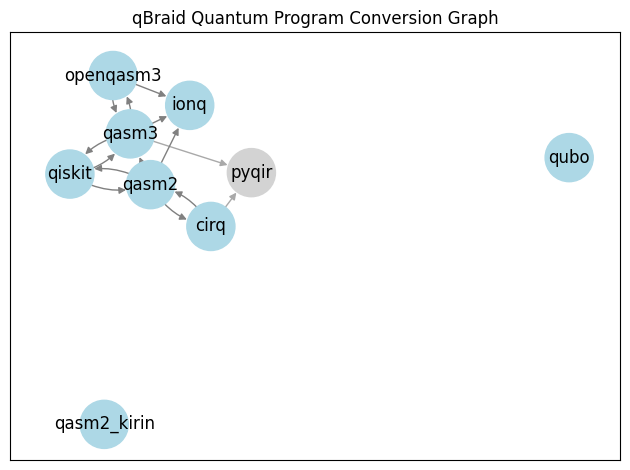

In [4]:
# Confirm graph

graph = ConversionGraph()
graph.plot()


In [5]:
def generate_circuit_for_problem() -> qiskit.QuantumCircuit:
    """
    Generates a quantum circuit using Qiskit
    """

    # Set up quantum circuit
    q = QuantumRegister(2)
    c = ClassicalRegister(2)
    circuit = QuantumCircuit(q, c)
    circuit.name = "Test Circuit"

    # Perform Bell Test
    circuit.h(q[0])
    circuit.cx(q[0], q[1])

    circuit.cx(q[0], q[1])
    circuit.cz(q[0], q[1])

    circuit.cy(q[0], q[1])
    circuit.cx(q[0], q[1])

    circuit.cx(q[0], q[1])

    # Measure all qubits
    circuit.measure(q, c)
    return circuit

qiskit_circuit = generate_circuit_for_problem()

In [6]:
# Convert to cirq so that we can use the cirq_to_qir function to get to the right format for some azure endpoints

cirq_circuit = transpile(qiskit_circuit, "cirq")

In [7]:
qir_circuit = cirq_to_qir(cirq_circuit)
qasm2_circuit = transpile(cirq_circuit, "qasm2")

print("QIR circuit is: \n")
print(str(qir_circuit))

print("QASM2 circuit is: \n")
print(qasm2_circuit)

QIR circuit is: 

; ModuleID = 'circuit-6a5681c'
source_filename = "circuit-6a5681c"

%Qubit = type opaque
%Result = type opaque

define void @main() #0 {
entry:
  call void @__quantum__rt__initialize(i8* null)
  call void @__quantum__qis__h__body(%Qubit* inttoptr (i64 1 to %Qubit*))
  call void @__quantum__qis__cnot__body(%Qubit* inttoptr (i64 1 to %Qubit*), %Qubit* null)
  call void @__quantum__qis__cnot__body(%Qubit* inttoptr (i64 1 to %Qubit*), %Qubit* null)
  call void @__quantum__qis__cz__body(%Qubit* inttoptr (i64 1 to %Qubit*), %Qubit* null)
  call void @__quantum__qis__s__adj(%Qubit* null)
  call void @__quantum__qis__cnot__body(%Qubit* inttoptr (i64 1 to %Qubit*), %Qubit* null)
  call void @__quantum__qis__s__body(%Qubit* null)
  call void @__quantum__qis__cnot__body(%Qubit* inttoptr (i64 1 to %Qubit*), %Qubit* null)
  call void @__quantum__qis__cnot__body(%Qubit* inttoptr (i64 1 to %Qubit*), %Qubit* null)
  call void @__quantum__qis__mz__body(%Qubit* inttoptr (i64 1 to %Qubi

In [8]:
provider = QbraidProvider()

# Rigetti Quantum Virtual Machine (simulator) and Ankaa-3

In [20]:
# Rigetti quantum virtual machine simulator

backend = provider.get_device("rigetti.sim.qvm")
job = backend.run(qir_circuit, shots=1000, entrypoint="main")

In [23]:
job.status()

<QUEUED: 'job is queued'>

In [ ]:
job.result()

In [22]:
backend = provider.get_device("rigetti.qpu.ankaa-3")
job = backend.run(qir_circuit, shots=1000, entrypoint="main")

ResourceNotFoundError: Device 'rigetti.qpu.ankaa-3' not found.

In [ ]:
job.status()

In [ ]:
job.result()

# Quantinuum H1-1 quantinuum.sim.h1-1sc

In [13]:

backend = provider.get_device("quantinuum.sim.h1-1sc")

job = backend.run(qasm2_circuit, shots=10)

In [18]:
job.status()

<COMPLETED: 'job has successfully run'>

In [19]:
job.result()  # Wait for the job to complete and get the results
result = job.result()
result.data.get_counts()  # Get the counts of the measurement results

{'00': 10}

In [ ]:
# This just means that the syntax checker passed. Now we can emulate!

# Quantinuum H1-1 Simulator quantinuum.sim.h1-1e

In [ ]:
# QASM2

backend = provider.get_device("quantinuum.sim.h1-1e")

job = backend.run(qasm2_circuit, shots=10)

In [ ]:
# Cancel job

# job.cancel()  

In [ ]:
job.status()

In [ ]:
job.wait_for_final_state()  
job.result()  # Wait for the job to complete and get the results
result = job.result()

In [ ]:
result.data.get_counts()  # Get the counts of the measurement results

# Quantinuum H1-1 QPU quantinuum.qpu.h1-1 

In [ ]:
# QASM2

backend = provider.get_device("quantinuum.qpu.h1-1")

job = backend.run(qasm2_circuit, entrypoint="main", shots=10)

In [ ]:
job.status()  # Check the status of the job

In [ ]:
job.cancel()  # Cancel the job


In [ ]:
result = job.result()  # Wait for the job to complete and get the results
result.data.get_counts()  # Get the counts of measurement results

In [ ]:
job.status()  # Check the status of the job

## IONQ

Submit to the ionq simulator or the ionq qpu

In [ ]:
backend = provider.get_device("ionq.simulator")  # List available devices

job = backend.run(
    qir_circuit,
    shots=10,  # Number of shots for the quantum job
)

In [ ]:
result = job.result()
result

In [ ]:
print(result.data.get_counts())  # Get the counts of measurement results

In [ ]:
# With noise
job = backend.run(qir_circuit, shots=1000, noise_model="aria-1", error_mitigation={"debias": False},seed=5)



In [ ]:
job.cancel()  # Cancel the job

In [ ]:
job.wait_for_final_state()

result = job.result()

In [ ]:
result.data.get_counts()  # Get the counts of measurement results

In [ ]:
backend = provider.get_device("ionq.qpu.aria-1")  # List available devices

job = backend.run(
    qir_circuit,
    shots=10,  # Number of shots for the quantum job
)

In [ ]:
result = job.result()
result

In [ ]:
result.data.get_counts()  # Get the counts of measurement results

## Pasqal 


In [ ]:
import pulser

input_data = {}
	
qubits = {
    "q0": (0, 0),
    "q1": (0, 10),
    "q2": (8, 2),
    "q3": (1, 15),
    "q4": (-10, -3),
    "q5": (-8, 5),
}
reg = pulser.Register(qubits)

seq = pulser.Sequence(reg, pulser.devices.DigitalAnalogDevice)

# print the available channels for your sequence
print(seq.available_channels)
# Declare a channel. In this example we will be using `rydberg_global`
seq.declare_channel("ch0", "rydberg_global")
from pulser.waveforms import RampWaveform, BlackmanWaveform
amp_wf = BlackmanWaveform(1000, np.pi)
det_wf = RampWaveform(1000, -5, 5)
pulse = pulser.Pulse(amp_wf, det_wf, 0)
seq.add(pulse, "ch0")

In [ ]:
backend = provider.get_device("pasqal.sim.emu-tn")

In [ ]:
job = backend.run(
    run_input=seq,
    shots=1,
)

In [ ]:
result = job.result()
result

In [ ]:
result.data.get_counts()  # Get the counts of measurement results

In [ ]:
backend = provider.get_device("pasqal.qpu.fresnel")

In [ ]:
%pip install pulser-pasqal
from pulser_pasqal import PasqalCloud

devices = PasqalCloud().fetch_available_devices()
QPU = devices["FRESNEL"]

In [ ]:
# let's say we are interested in the first layout available on the device
layout = QPU.pre_calibrated_layouts[0]
# Select traps 1, 3 and 5 of the layout to define the register
traps = [1,3,5]
reg = layout.define_register(*traps)
# You can draw the resulting register to verify it matches your expectations
reg.draw()

In [ ]:
seq = pulser.Sequence(reg, QPU)

# print the available channels for your sequence
print(seq.available_channels)
# Declare a channel. In this example we will be using `rydberg_global`
seq.declare_channel("ch0", "rydberg_global")
from pulser.waveforms import RampWaveform, BlackmanWaveform
amp_wf = BlackmanWaveform(1000, np.pi)
det_wf = RampWaveform(1000, -5, 5)
pulse = pulser.Pulse(amp_wf, det_wf, 0)
seq.add(pulse, "ch0")

In [ ]:
job = backend.run(
    run_input=seq,
    shots=1,
)

In [ ]:
job.cancel()  # Cancel the job

In [ ]:
job.status()

In [ ]:
result = job.result()
result

In [ ]:
result.data.get_counts()  # Get the counts of measurement results